In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

In [2]:
data= pd.read_excel("C:/Users/SANJAY/Desktop/ExcelR/Assignments/Assignment - 18/Forecasting/CocaCola_Sales_Rawdata.xlsx")
data.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [3]:
data.shape

(42, 2)

In [4]:
data.isnull().any()

Quarter    False
Sales      False
dtype: bool

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [6]:
data.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


In [7]:
data.corr()

,Sales
Sales,1.0


In [8]:
data.nunique()

Quarter    42
Sales      42
dtype: int64

In [9]:
# We will extract Quarter values and Year values separately from 'Quarter column'
data['Quarters'] = 0
data['Year'] = 0
for i in range(42):
    p = data['Quarter'][i]
    data['Quarters'][i] = p[0:2]
    data['Year'][i] = p[3:5]

In [10]:
data.head()

,Quarter,Sales,Quarters,Year
0,Q1_86,1734.827000,Q1,86
1,Q2_86,2244.960999,Q2,86
2,Q3_86,2533.804993,Q3,86
3,Q4_86,2154.962997,Q4,86
4,Q1_87,1547.818996,Q1,87


In [11]:
# Getting dummy variables for Quarters Q1, Q2, Q3, Q4 
Quaters_dummies = pd.DataFrame(pd.get_dummies(data['Quarters']))
data = pd.concat([data,Quaters_dummies],axis=1)
data.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,86,1,0,0,0
1,Q2_86,2244.960999,Q2,86,0,1,0,0
2,Q3_86,2533.804993,Q3,86,0,0,1,0
3,Q4_86,2154.962997,Q4,86,0,0,0,1
4,Q1_87,1547.818996,Q1,87,1,0,0,0


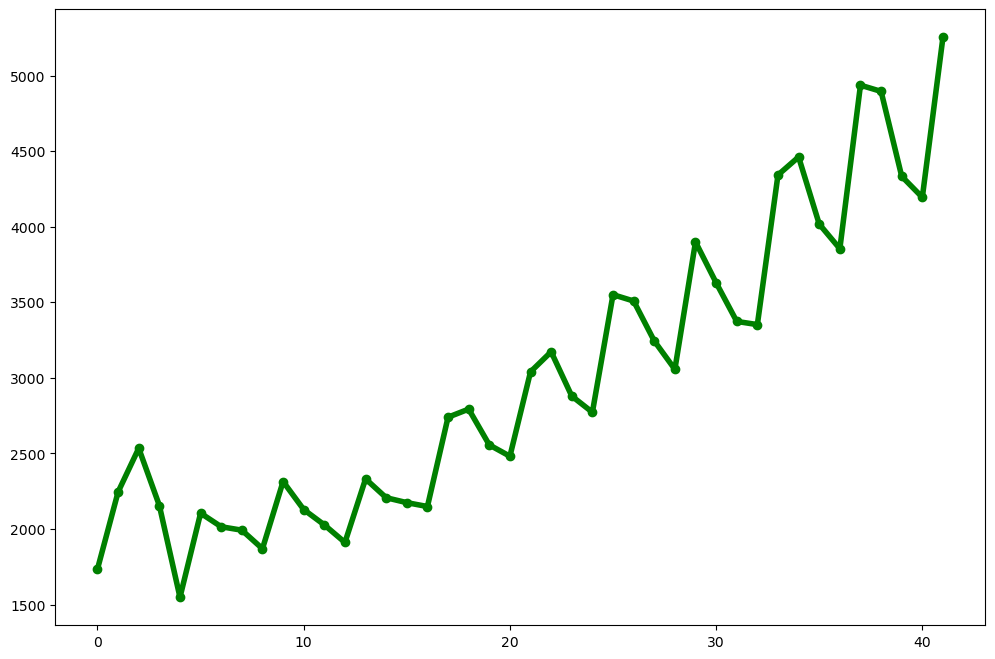

In [12]:
#Line plot
plt.figure(figsize=(12,8))
plt.plot(data['Sales'], color = 'green', linewidth=4, marker='o')

<AxesSubplot:>

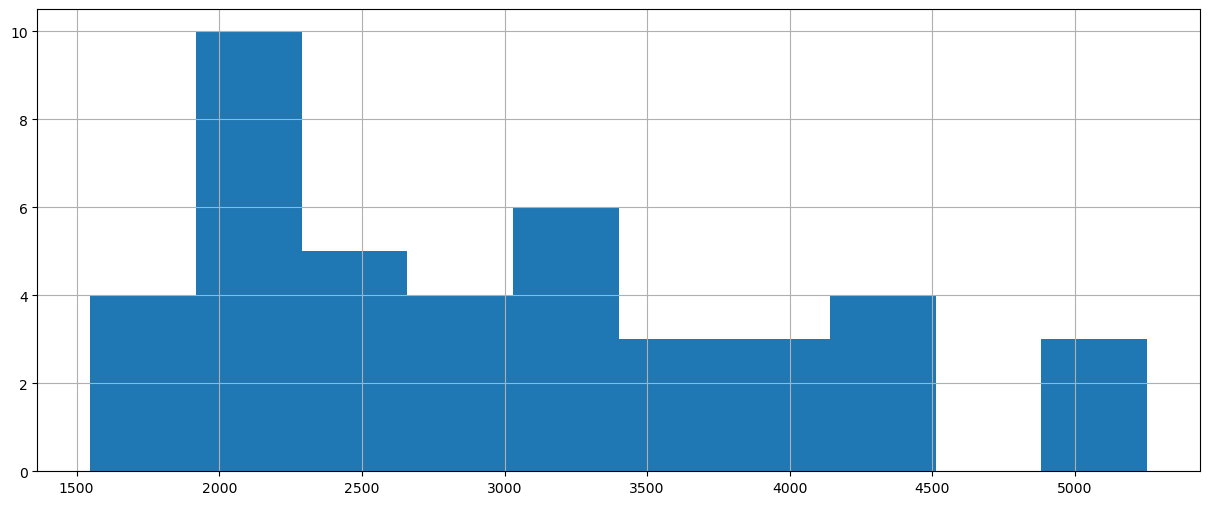

In [13]:
#Histogram
data['Sales'].hist(figsize=(15,6))

<AxesSubplot:ylabel='Density'>

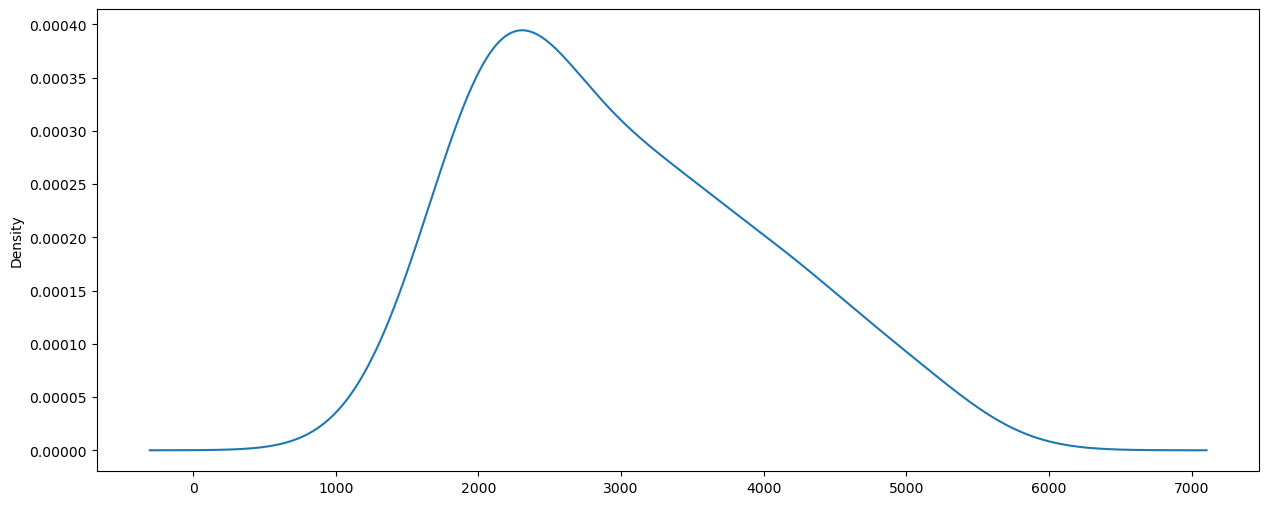

In [14]:
#Density plot
data['Sales'].plot(kind = 'kde', figsize=(15,6))

<AxesSubplot:xlabel='Quarters', ylabel='Sales'>

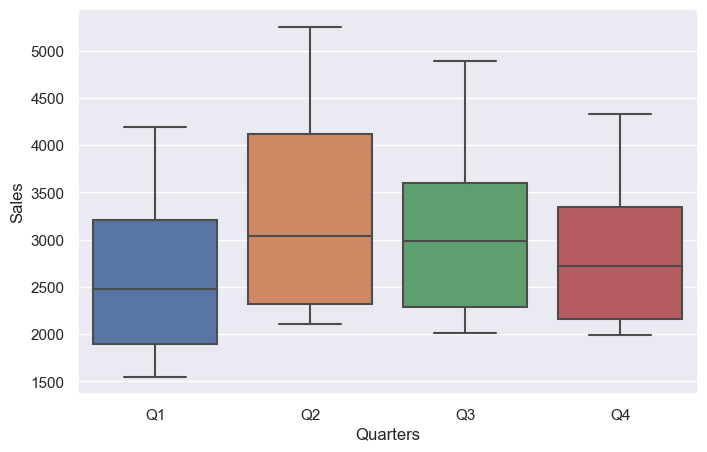

In [15]:
#boxplot of Quarters Vs. Sales
sns.set(rc={'figure.figsize':(8,5)})
sns.boxplot(x="Quarters",y="Sales",data=data)

<AxesSubplot:xlabel='Year', ylabel='Sales'>

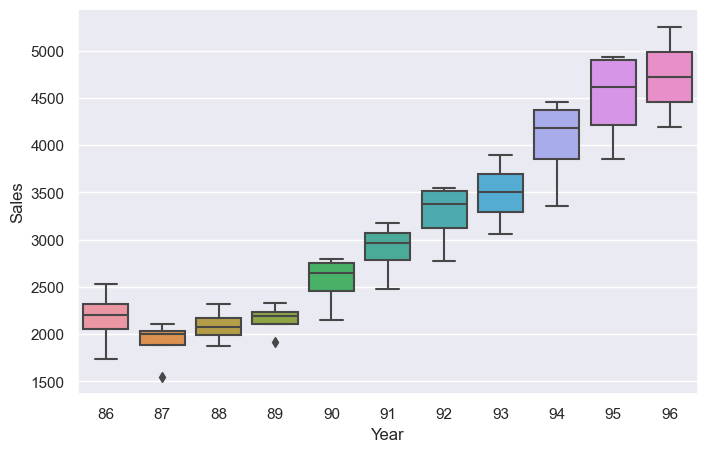

In [16]:
sns.boxplot(x="Year",y="Sales",data=data)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


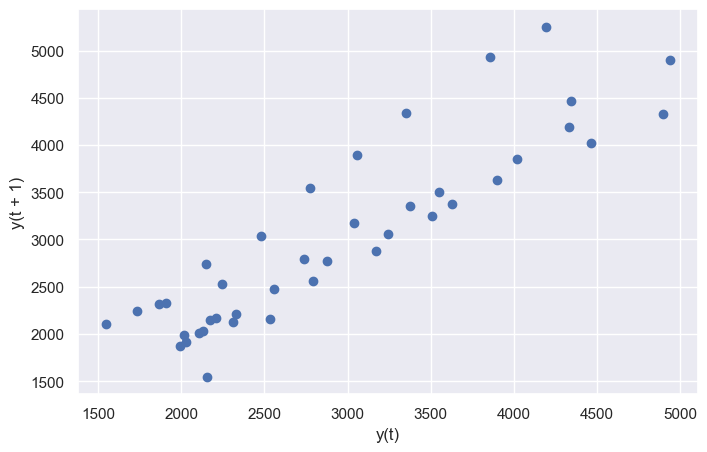

In [17]:
#Lag plot
from pandas.plotting import lag_plot
lag_plot(data['Sales'])
plt.show()

<AxesSubplot:xlabel='Year', ylabel='Sales'>

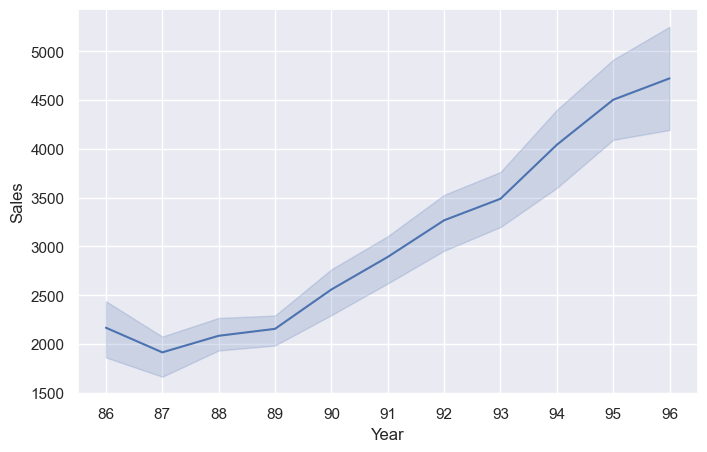

In [18]:
sns.lineplot(x='Year',y='Sales',data = data)

<AxesSubplot:xlabel='Quarters', ylabel='Year'>

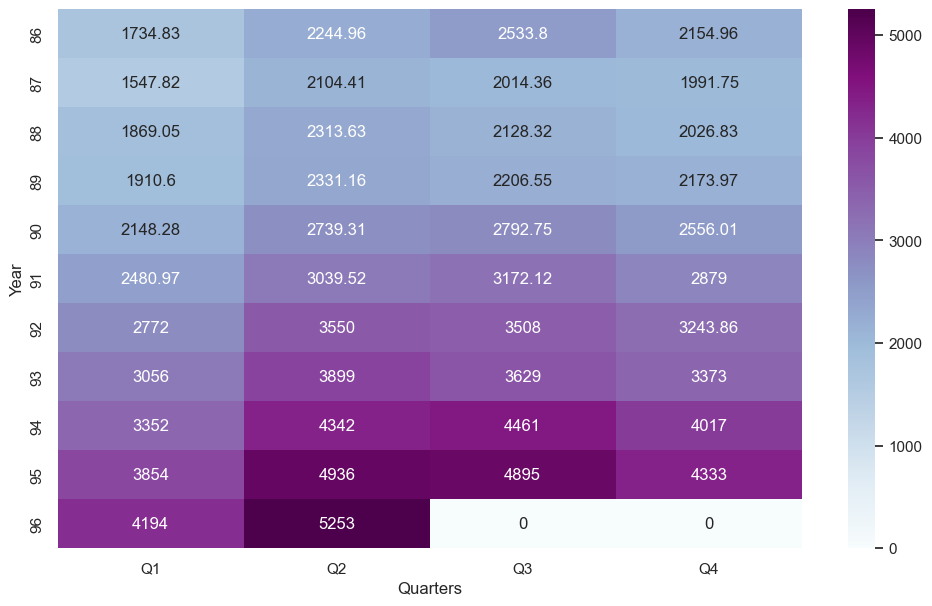

In [19]:
plt.figure(figsize=(12, 7))
heatmap_y_month = pd.pivot_table(data=data,values="Sales",index="Year",columns="Quarters",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,cmap='BuPu',fmt="g")

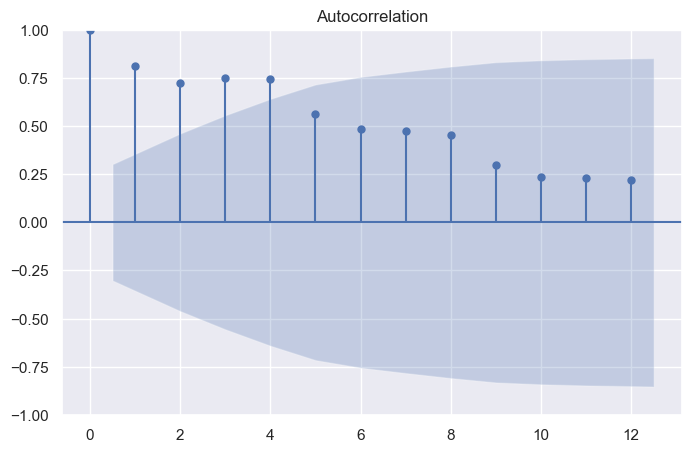

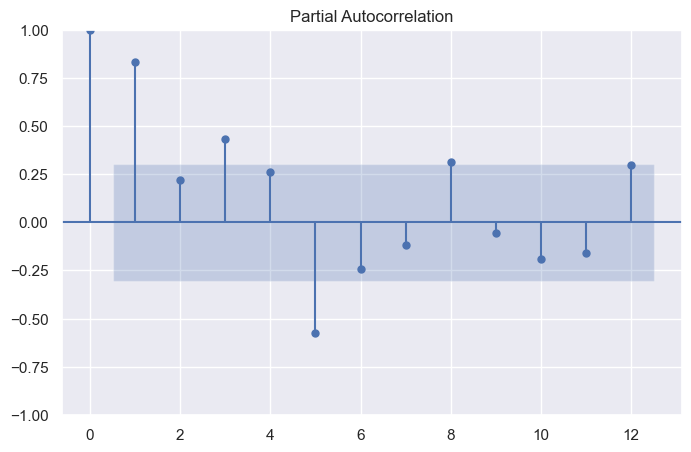

In [20]:
import statsmodels.graphics.tsaplots as tsa_plots
tsa_plots.plot_acf(data.Sales,lags=12)
tsa_plots.plot_pacf(data.Sales,lags=12)
plt.show()

# Splitting Data

In [21]:
Train = data.head(32)
Test = data.head(10)

In [22]:
Train.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1,86,1,0,0,0
1,Q2_86,2244.960999,Q2,86,0,1,0,0
2,Q3_86,2533.804993,Q3,86,0,0,1,0
3,Q4_86,2154.962997,Q4,86,0,0,0,1
4,Q1_87,1547.818996,Q1,87,1,0,0,0


# Moving Average Method

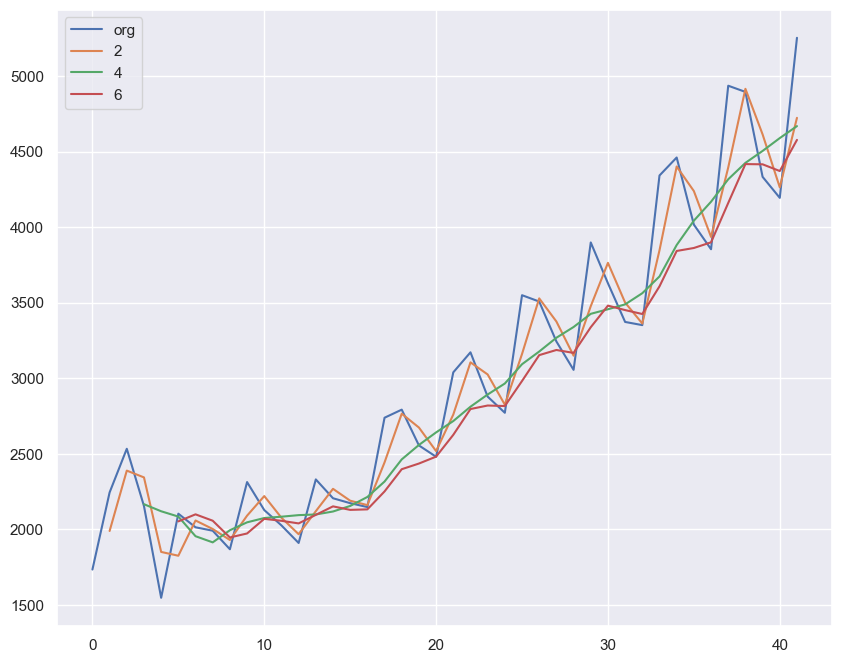

In [23]:
plt.figure(figsize=(10,8))
data.Sales.plot(label='org')
for i in range(2,8,2):
    data['Sales'].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

# Time series decomposition plot

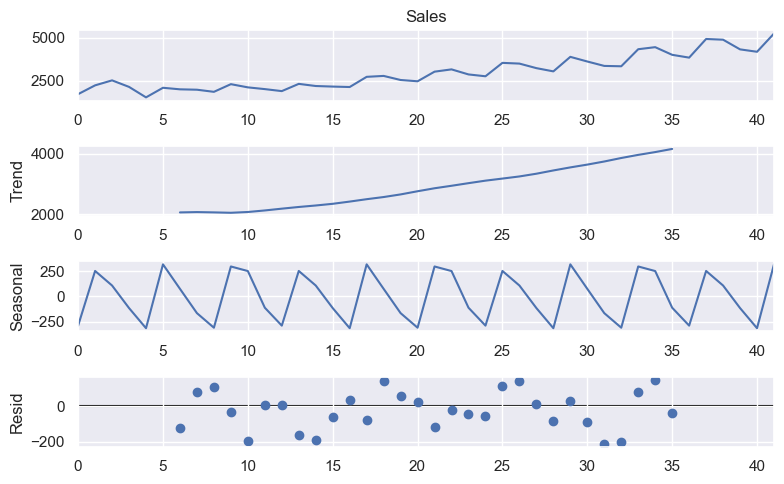

In [24]:
decompose_ts_add = seasonal_decompose(data.Sales,period=12)
decompose_ts_add.plot()
plt.show()

# Evaluation Metric RMSE

In [25]:
def RMSE(org,pred):
    rmse=np.sqrt(np.mean((np.array(org)-np.array(pred))**2))
    return rmse

# Simple Exponential Method

In [26]:
ses_model = SimpleExpSmoothing(Train['Sales']).fit()
pred_ses = ses_model.predict(start=Test.index[0], end = Test.index[-1])
rmse_ses_model = RMSE(Test.Sales,pred_ses)
rmse_ses_model

341.3578919550179

# Holt method

In [27]:
hw_model = Holt(Train["Sales"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_hw_model = RMSE(Test.Sales, pred_hw)
rmse_hw_model

361.2872012866536

# Holts winter exponential smoothing with additive seasonality and additive trend

In [28]:
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=4).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_add_add_model = RMSE(Test.Sales, pred_hwe_add_add)
rmse_hwe_add_add_model

201.41155914652688

# Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [29]:
hwe_model_mul_add = ExponentialSmoothing(Train['Sales'],seasonal='mul',trend='mul',seasonal_periods=4).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start=Test.index[0],end=Test.index[-1])
rmse_hwe_model_mul_add_model = RMSE(Test.Sales, pred_hwe_mul_add)
rmse_hwe_model_mul_add_model

198.15290119397898

# Model based Forecasting Methods

In [30]:
data['t'] = np.arange(1,43)
data['t_squared'] = data['t']*data['t']

data['log_sales'] = np.log(data['Sales'])
data.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4,t,t_squared,log_sales
0,Q1_86,1734.827000,Q1,86,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2,86,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3,86,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4,86,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1,87,1,0,0,0,5,25,7.344602


# Splitting data

In [31]:
# Splitting data into Train and Test (77/33)
Train = data.head(32)
Test = data.tail(10)
Train.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4,t,t_squared,log_sales
0,Q1_86,1734.827000,Q1,86,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2,86,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3,86,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4,86,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1,87,1,0,0,0,5,25,7.344602


# Linear Model

In [32]:

liner_model = smf.ols('Sales~t',data=Train).fit()
pred_linear=pd.Series(liner_model.predict(pd.DataFrame(Test['t'])))
rmse_linear_model=RMSE(Test['Sales'],pred_linear)
rmse_linear_model

752.9233932767121

# Exponential Model

In [33]:
Exp = smf.ols('log_sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp_model = RMSE(Test['Sales'], np.exp(pred_Exp))
rmse_Exp_model            

590.3316432076657

# Quadratic Model

In [34]:
Quad = smf.ols('Sales~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad_model = RMSE(Test['Sales'], pred_Quad)
rmse_Quad_model

457.7357355407437

# Additive Seasonality model

In [35]:
add_sea = smf.ols('Sales~Q1+Q2+Q3',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Q1', 'Q2', 'Q3']]))
rmse_add_sea = RMSE(Test['Sales'], pred_add_sea)
rmse_add_sea

1850.4665461858358

# Additive Seasonality Quadratic model

In [36]:
add_sea_Quad = smf.ols('Sales~t+t_squared+Q1+Q2+Q3',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Q1','Q2','Q3','t','t_squared']]))
rmse_add_sea_Quad_model = RMSE(Test['Sales'], pred_add_sea_quad)
rmse_add_sea_Quad_model 

277.351077112877

# Multiplicative Seasonality model

In [37]:
Mul_sea = smf.ols('log_sales~Q1+Q2+Q3',data=Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mul_sea = RMSE(Test['Sales'], np.exp(pred_Mult_sea))
rmse_Mul_sea

1908.2503948361139

# Multiplicative Additive Seasonality model

In [38]:
Mul_Add_sea = smf.ols('log_sales~t+Q1+Q2+Q3',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mul_Add_sea = RMSE(Test['Sales'], np.exp(pred_Mult_add_sea))
rmse_Mul_Add_sea

448.8678182691915

In [39]:
list = [['Simple Exponential Method',rmse_ses_model], ['Holt method',rmse_hw_model],
          ['HW exp smoothing add',rmse_hwe_add_add_model],['HW exp smoothing mult',rmse_hwe_model_mul_add_model],
          ['Linear Mode',rmse_linear_model],['Exp model',rmse_Exp_model],['Quad model',rmse_Quad_model],
          ['add seasonality',rmse_add_sea],['Quad add seasonality',rmse_add_sea_Quad_model],
          ['Mult Seasonality',rmse_Mul_sea],['Mult add seasonality',rmse_Mul_Add_sea]]

In [40]:
# RMSE values for all models
df = pd.DataFrame(list,columns=['Model','RMSE_Values'])
df

,Model,RMSE_Values
0,Simple Exponential Method,341.357892
1,Holt method,361.287201
2,HW exp smoothing add,201.411559
3,HW exp smoothing mult,198.152901
4,Linear Mode,752.923393
5,Exp model,590.331643
6,Quad model,457.735736
7,add seasonality,1850.466546
8,Quad add seasonality,277.351077
9,Mult Seasonality,1908.250395


# Building final model with least RMSE value

In [41]:
data.head()

,Quarter,Sales,Quarters,Year,Q1,Q2,Q3,Q4,t,t_squared,log_sales
0,Q1_86,1734.827000,Q1,86,1,0,0,0,1,1,7.458663
1,Q2_86,2244.960999,Q2,86,0,1,0,0,2,4,7.716443
2,Q3_86,2533.804993,Q3,86,0,0,1,0,3,9,7.837477
3,Q4_86,2154.962997,Q4,86,0,0,0,1,4,16,7.675529
4,Q1_87,1547.818996,Q1,87,1,0,0,0,5,25,7.344602


In [42]:
final_model = smf.ols('Sales~t+t_squared+Q1+Q2+Q3',data=data).fit()
pred_final = pd.Series(final_model.predict(data[['Q1','Q2','Q3','t','t_squared']]))
rmse_final_model = RMSE(data['Sales'], pred_final)
rmse_final_model

159.05522576522472

In [43]:
pred_df = pd.DataFrame({'Actual' : data.Sales, 'Predicted' : pred_final})
pred_df

,Actual,Predicted
0,1734.827000,1626.592727
1,2244.960999,2268.402339
2,2533.804993,2189.685821
3,2154.962997,1867.242917
4,1547.818996,1658.311143
5,2104.411995,2314.185178
6,2014.362999,2249.533083
7,1991.746998,1941.154603
8,1869.049999,1746.287252
9,2313.631996,2416.225709


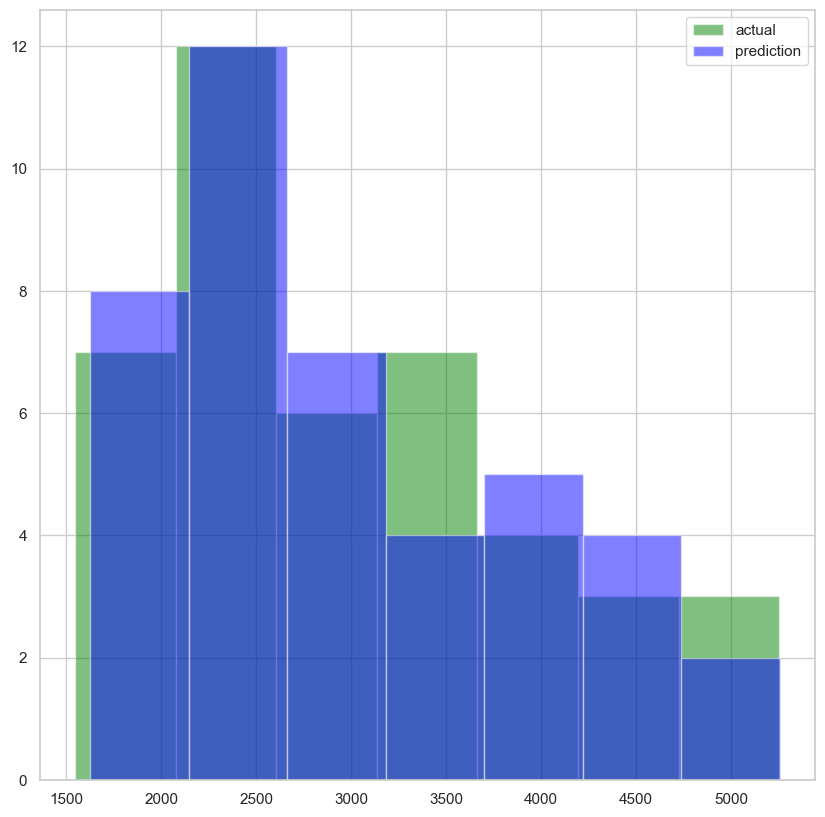

In [44]:
# Actual Vs Predicted graph
sns.set_style('whitegrid')
plt.figure(figsize=(10,10))
plt.hist(data.Sales, color = 'green', alpha = 0.5, label = 'actual', bins=7)
plt.hist(pred_final, color = 'blue', alpha = 0.5, label = 'prediction', bins=7)

plt.legend(loc = 'best')
plt.show()


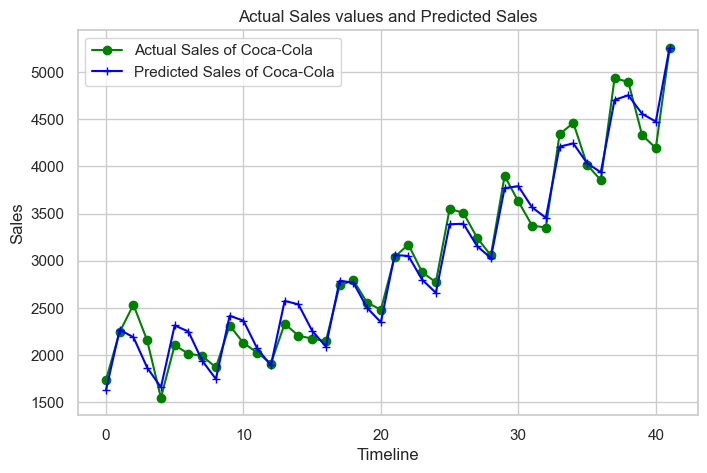

<Figure size 1500x1000 with 0 Axes>

In [46]:
# Plot of Actual Sales values and Predicted sales values
plt.plot(data.Sales, color='green', marker='o',label = 'Actual Sales of Coca-Cola')
plt.plot(pred_final, color = 'blue', marker='+',label= 'Predicted Sales of Coca-Cola')

plt.title('Actual Sales values and Predicted Sales')
plt.xlabel('Timeline')
plt.ylabel('Sales')
plt.legend()
plt.figure(figsize=(15,10))
plt.show()